#### [詳解ディープラーニング　TensorFlow・Kerasによる時系列データ処理](https://book.mynavi.jp/ec/products/detail/id=72995)
　巣籠悠輔 著  
  
support site : [https://book.mynavi.jp/supportsite/detail/9784839962517.html](https://book.mynavi.jp/supportsite/detail/9784839962517.html)  
github : [yusugomori/deeplearning-tensorflow-keras](https://github.com/yusugomori/deeplearning-tensorflow-keras) 


---
## 第４章　ディープニューラルネットワーク

隠れ層を増やした"深い"ネットワークをディープニューラルネットワークと呼び、  
これを用いる学習を深層学習（deep learning）と呼ぶ。  
  
（注記：活性化関数がステップ関数である３層以下（隠れ層１層まで）の浅いネットワークをパーセプトロン、  
　シグモイド関数などを用い、多層化しているものをディープニューラルネットワークと  
　呼ぶ用法が多いように見受けられるが、厳密な定義を確認できなかったため  
　このnotebookでは書籍の記述に従う。）  

data shape is  (70000, 784)
target shape is  (70000,)
type of target is  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


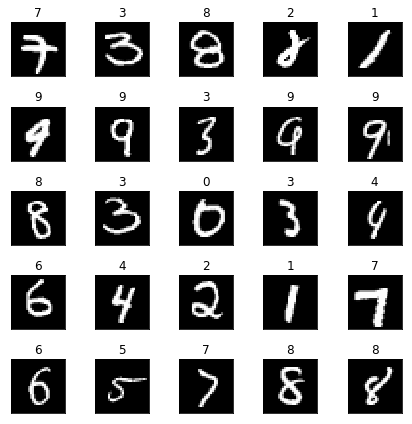

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home="./dataset")

def show_sample(n=25):
    p = np.random.randint(0,len(mnist.data), n)
    fig = plt.figure(figsize=(6,6))
    ax = {}
    for i in range(n):
        data, label = mnist.data[p[i]], mnist.target[p[i]]
        ax[i] = fig.add_subplot(int(np.sqrt(n)),int(np.sqrt(n)),i+1)
        ax[i].tick_params(labelbottom='off', bottom='off', labelleft='off', left='off')
        ax[i].imshow(data.reshape(28,28), cmap='gray')
        ax[i].set_title(int(label))
    plt.tight_layout()
    plt.show()

print("data shape is ", mnist.data.shape)
print("target shape is ", mnist.target.shape)
print("type of target is ", np.unique(mnist.target))
show_sample()

MNISTデータセットは70000枚の画像データを含むが、  
簡便のため10000枚をランダムに抽出して以下の実験に用いる。  

In [5]:
# データ抽出の例
import numpy as np
from sklearn.model_selection import train_test_split

indices = np.random.permutation(len(mnist.data))
X = mnist.data[indices]
Y = mnist.target[indices]
Y_onehot = np.eye(10)[Y.astype(int)]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, train_size=0.8, test_size=0.2)

隠れ層が１層のMLPでの例

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

indices = np.random.permutation(len(mnist.data))[:N]
X = mnist.data[indices]
Y = mnist.target[indices]
Y_onehot = np.eye(10)[Y.astype(int)]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_onehot, train_size=0.8, test_size=0.2)

n_in, n_hidden, n_out = X[0].shape[0], 200, Y_onehot[0].shape[0]

model = Sequential()
model.add(Dense(n_hidden, input_dim=n_in))
model.add(Activation('sigmoid'))
model.add(Dense(n_out))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=SGD(lr=0.01), 
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=1000, batch_size=100, verbose=0)
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

32/60 [===============>..............] - ETA: 0s[0.82040030558904009, 0.69999999602635699]


MLPの隠れ層のニューロン数を変えながら３回ずつ試験した結果は次の通りだった。  
値は小数点第３位で四捨五入した。  
  
| the number of neurons in hidden layer | mean accuracy (%) | accuracy data(%)
|--:|:-:|:-:|
|200|71.67| 68.33, 76.67, 70.00 |
|400|76.11| 68.33, 73.33, 86.67 |
|2000|79.44| 78.33, 75.00, 85.00 |
|4000|80.56| 86.67, 78.33, 76.67 |
|6000|76.11| 80.00, 68.33, 80.00 |


次にニューロン数を200に固定し、隠れ層を増やして各３回実験した。
具体的には、以下のコードを隠れ層として追加した。

~~~python
model.add(Activation('sigmoid'))
model.add(Dense(n_hidden))
~~~

結果は次の通り。

| the number of hidden layers | mean accuracy (%)| accuracy data (%) |
|--:|:-:|:-:|
| 1 | 72.22 | 71.67, 68.33, 76.67 |
| 2 | 66.67 | 56.67, 68.33, 75.00 |
| 3 | 51.67 | 50.00, 56.67, 48.33 |
| 4 | 18.33 | 21.67, 26.67, 6.67 |
| 5 | 11.11 | 11.67, 8.33, 13.33 |


単純な多層化やニューロン数の増加によっては性能改善はどこかのタイミングで頭打ちになることが知られており、  
その原因の１つは勾配消失問題である。  

---
### 勾配消失問題
M.Nielsenの表記に従い、第 $l$ 層 $j$ 番目のニューロンの誤差 $\delta^{l}_{j}$ を次のように定義する。  
ここで $C$ は誤差関数の値、$a^{l}_{j}$ は活性、$z^{l}_{j}$ はこのニューロンにおける活性化関数への重み付き入力である。     
  
\begin{align*}
\delta^{l}_{j} := \frac{\partial C}{\partial z^{l}_{j}}
\end{align*}

前回のノート(~_2.ipynb 参照)での議論から、誤差逆伝播法における各層の誤差は

\begin{align*}
\delta^{l} = ((w^{l+1})^{\mathrm{T}} \delta^{l+1}) \odot f^{\prime}(z^{l})
\end{align*}

であり、重みは

\begin{align*}
\frac{\partial C}{\partial w^{l}_{jk}} = a^{l-1}_{k} \delta^{l}_{j}
\end{align*}

すなわち

\begin{align*}
\frac{\partial C}{\partial w} = a_{in} \delta_{out}
\end{align*}

と書ける。  
  
さて、上の実験では活性化関数としてsigmoid関数を用いたが、その式と導関数は

\begin{align*}
\sigma(x) &= \frac{1}{1+\exp(-x)} \\
\sigma(x)^{\prime} &= \sigma(x)(1-\sigma(x))
\end{align*}

であり、そのグラフは下図のようになる。

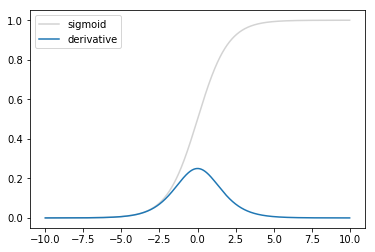

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from math import log

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))

x = np.arange(-10,10,0.01)
#y = sigmoid(x)
#plt.figure(figsize=(4,3))
plt.plot(x,sigmoid(x), color='lightgray', label='sigmoid')
plt.plot(x,sigmoid_prime(x), label='derivative')
plt.legend()
plt.show() 

このようにsigmoid関数の導関数は値が小さく、$\sigma^{\prime}(x) \leq 0.25$ であるから、  
誤差を求める漸化式が $f^{\prime}(z^{l})$ の項を含むことより  
一層につき誤差の絶対値が0.25倍以下になることがわかる。  
この問題は、活性化関数へ入力する値の絶対値が大きいほど顕著である。  

これが勾配消失問題の要因の１つであり、  
微分が小さくない、誤差を減少させない活性化関数が求められることとなった。  
  
（ニューラルネットワークには勾配爆発問題もあり、これは誤差が逆伝播により急激に大きくなる問題である。  
　これらの根本は、前方の層の勾配がそれ以降の層の勾配の積となっているために  
　ニューラルネットワークが不安定勾配問題を伴っていることである。）    

---
### Overfitting

一般に過学習あるいは過剰適合と呼ばれる問題である。  
  
例として、 $f(x) = cos \left( \frac{3 \pi}{2}x \right)$ に従う分布から得られた30個のデータ $\{x_{i}\}$ があるとする。  
真の分布が未知であるとして、この分布を多項式関数  

\begin{align*}
\hat{f}(x) = a_{0} + a_{1}x + a_{2}x^{2} + \cdots + a_{n}x^{n} = \sum_{i=0}^{n}a_{i}x^{i}
\end{align*}

によって近似することを考える。  
  
下図は、それぞれ１次、４次、１６次、６４次の関数によって近似した結果の一例である。

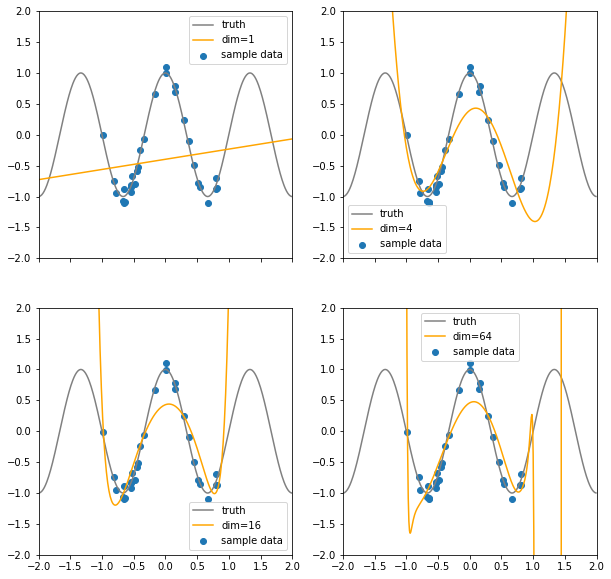

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def target_f(x):
    return np.cos((3*np.pi*x)/2)

def aprox(X, Y, n, epochs=1000):
    Xe = np.array([[X[i]**j for j in range(n+1)] for i in range(X.shape[0])]).reshape(30,n+1)
    
    x = tf.placeholder(tf.float32, shape=[None, n+1])
    t = tf.placeholder(tf.float32, shape=[None, 1])
    
    W = tf.Variable(tf.truncated_normal([n+1,1]))
    y = tf.matmul(x,W)
    
    loss = tf.losses.mean_squared_error(t,y)
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    for epoch in range(epochs):
        X_, Y_ = shuffle(Xe, Y)
        sess.run(train_step, feed_dict={
            x: X_,
            t: Y_
        })
        
    return sess.run(W).reshape(n+1)

def predict(W,X):
    ya = []
    for x in X:
        yv = W * [x**j for j in range(len(W))]
        ya.append(np.sum(yv))
    return np.array(ya)

# dataset
#X = np.random.rand(30,1)
X = (np.random.rand(30,1)-0.5)*2
Y = np.cos((3*np.pi*X)/2) + (np.random.rand(30,1)-0.5)*0.3

W1 = aprox(X,Y,1)
W4 = aprox(X,Y,4)
W16 = aprox(X,Y,16)
W64 = aprox(X,Y,64)

# plot
xmin, xmax = -2,2
ymin, ymax = -2,2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,10), sharex=True)
xline = np.arange(xmin, xmax, .01)

for ax, W, l in zip([ax1,ax2,ax3,ax4], [W1,W4,W16,W64], ['dim=1','dim=4','dim=16','dim=64']):
    ax.plot(xline, target_f(xline), color='gray', label='truth')
    ax.scatter(X,Y,label='sample data')
    ax.plot(xline, predict(W,xline), color='orange', label=l)
    ax.legend()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.show()

上図に徴候が現れているが、近似式の次数が増加するに従い  
与えられたデータのみに過剰に適合する結果として真の分布から遠ざかる傾向がみられ、  
この状態を Overfitting という。  

---
WIP
    

---
### 学習の効率化